In [26]:
# adds parent dir to python path
import sys
sys.path.insert(0, '..')

import os

import numpy as np
import sep
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

import gphelper as gp
import ImageTools as it
import DataTools as dt

In [2]:
def make_nonnegative(img):
    epsilon = 0 if len(img[img<0])==0 else img[img>0].min()
    return img + abs(img.min()) + epsilon

def get_random_spheroids(num=10):
    with open('../spheroids', 'r') as f:
        spheroids = np.array(f.readlines())
    
    if num==-1:
        num = len(spheroids)
    
    selected = np.random.choice(spheroids, num, replace=False)
    
    data_dir = os.path.join(os.getenv('HOME'), 'Documents/astro_data/orig_images')
    fmask = 'GDS_{}_{}.fits'
    f_string = os.path.join(data_dir, fmask)

    sources = []
    for s in selected:
        img = fits.getdata(f_string.format(s.strip(), 'h'))
        segmap = fits.getdata(f_string.format(s.strip(), 'segmap'))
        img_id = int(s.split('_')[1])
        sources.append((img.copy(), segmap.copy(), img_id))
        del img 
        del segmap
    
    return sources

In [120]:
def convergence_update(re, is_converged, int_at_re, int_at_limit, rs):
    tolerance = 1e-3
    
    ratio = (int_at_re/int_at_limit-0.5)
    
    if (ratio > tolerance):
        re = rs[np.nonzero(rs==re)[0][0]-1]
    elif (ratio < -tolerance):
        re = rs[np.nonzero(rs==re)[0][0]+1]
    else:
        is_converged = True
        
    print(f'New re:{re} from ratio:{int_at_re}/{int_at_limit}-0.5={ratio}')
        
    return re, is_converged

def check_stop_condition(count, max_attempts, re, rs, fs):
    stop = False
    
    if count==max_attempts:
        print('Max Attempts Reached')
        stop = True
        re_idx = ((np.cumsum(fs)/fs.sum())-0.5).argmin()
        re = rs[re_idx]
        
    elif 5*re >= 42:
        print('Overgrown Image')
        stop = True
        re_idx = np.square((np.cumsum(fs)/fs.sum())-0.5).argmin()
        re = rs[re_idx]
        
    return re, stop, rs.max()

def segmap_too_small(src_map):
    area = src_map.sum()
    r = np.sqrt(area/np.pi)
    return r<=15

def closest_r(rs, r):
    r_idx = np.square(rs-r).argmin()
    return rs[r_idx]

def in_segmap_integration(rs, fs):
    

spheroids = get_random_spheroids(num=100)
num_converged, total, num_too_small  = 0, len(spheroids), 0
found_res, rs_re, fs_ie = [], [], []

for img, segmap, img_id in spheroids:
    src_map = segmap==img_id
    array_sep_likes = img.byteswap().newbyteorder()
    bkg = sep.Background(array_sep_likes, mask=src_map,bw=10,bh=10)
    img_sub = make_nonnegative(img-bkg)

    cx, cy = it.img_center(img, src_map)
    xs, ys = np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]).T)
    rs = np.sqrt(np.square(cx-xs) + np.square(cy-ys))
    
    if segmap_too_small(src_map):
        print(f'{img_id} segmap too small')
        #take measurement within segmap only
        rs = rs[src_map].flatten()
        fs = img_sub[src_map].flatten()
        
        sorted_rs = np.argsort(rs)
        rs = rs[sorted_rs]
        fs = fs[sorted_rs]
        fs[fs<0] = 0
        
        fs_int = np.cumsum(fs) 
        
        re_idx = np.argmin(np.square(fs_int/fs.sum()-0.5))
        re = rs[re_idx]
        ie = fs[re_idx]
        
        fs /= ie
        rs /= re
        
        fs_int = np.cumsum(fs) / fs.sum()
        
    else:
        # find using iterative method
        rs = rs.flatten()
        fs = img_sub.flatten()

        sorted_rs = np.argsort(rs)
        rs = rs[sorted_rs]
        fs = fs[sorted_rs]

        #fs[fs<0] = 0

        fs_int = np.cumsum(fs) 

        re = rs.min()#closest_r(rs, 0.05 * rs.max())
        print(f'Initial RE:{re}')
        is_converged = False
        max_attempts = 1000
        count = 0

        while not is_converged:
            int_limit = closest_r(rs, 5*re)
            int_at_re = fs_int[rs==re]
            int_at_limit = fs_int[rs==int_limit]
            
            
            
            re, is_converged = convergence_update(re, 
                                                  is_converged,
                                                  int_at_re,
                                                  int_at_limit,
                                                  rs)
            #re = closest_r(rs, re)

            if not is_converged:
                re, is_converged, int_limit = check_stop_condition(count, 
                                                                   max_attempts, 
                                                                   re,
                                                                   rs,
                                                                   fs)

            count += 1
            
        ie = fs[rs==re].mean()
        
        fs = fs[rs<=int_limit]
        rs = rs[rs<=int_limit]
        
        rs /= re
        fs /= ie
        
        fs_int = np.cumsum(fs) / fs.sum()
        #rs = rs[rs<=5]
        
    rs_re.append(rs)
    fs_ie.append(fs_int)
        
    found_res.append(re)
        
    if len(spheroids)<5:
        plt.figure()
        plt.title(img_id)
        plt.plot(rs, fs_int)
        plt.vlines([1], fs_int.min(), 1)
        plt.hlines([0.5], 0, rs.max())
                   
        #plt.vlines([re], fs_sub_int.min(), fs_sub_int.max(), color='g', label='$R_e$')
        #plt.vlines([int_limit], fs_sub_int.min(), fs_sub_int.max(), color='r', label="$5R_e$")
        #plt.legend()
        plt.show()

4583 segmap too small
3210 segmap too small
Initial RE:0.5405799638194206
New re:0.5623699406388524 from ratio:[ 2.89843655]/[ 37.25311279]-0.5=[-0.42219612]
New re:0.9094191485206284 from ratio:[ 5.88369083]/[ 40.26919556]-0.5=[-0.35389102]
New re:0.9225380428725556 from ratio:[ 8.88024044]/[ 65.60152435]-0.5=[-0.36463362]
New re:1.3256734918033277 from ratio:[ 11.59206581]/[ 66.1150589]-0.5=[-0.32466829]
New re:1.3347072561881004 from ratio:[ 13.19600773]/[ 86.85588074]-0.5=[-0.34807009]
New re:1.506052271480597 from ratio:[ 14.80458832]/[ 87.2770462]-0.5=[-0.33037248]
New re:1.5298016874697473 from ratio:[ 16.17999268]/[ 93.3669281]-0.5=[-0.32670531]
New re:1.6742192015518294 from ratio:[ 17.73410797]/[ 94.43585205]-0.5=[-0.31221002]
New re:1.695614842291216 from ratio:[ 19.51082802]/[ 98.88315582]-0.5=[-0.30268806]
New re:1.8335374766033457 from ratio:[ 20.97395134]/[ 99.22956848]-0.5=[-0.28863204]
New re:1.8400795990826333 from ratio:[ 22.02127457]/[ 103.4963913]-0.5=[-0.28722665]

New re:3.150789037725794 from ratio:[ 20.68955231]/[ 99.38021851]-0.5=[-0.29181418]
New re:3.1809179100393314 from ratio:[ 21.23438454]/[ 99.72459412]-0.5=[-0.28706974]
New re:3.2261556621294436 from ratio:[ 21.62786293]/[ 100.40625]-0.5=[-0.28459644]
New re:3.2393961408916865 from ratio:[ 22.09806442]/[ 101.59597015]-0.5=[-0.28249073]
New re:3.2877299043701202 from ratio:[ 22.59296036]/[ 101.75398254]-0.5=[-0.27796486]
New re:3.3066419976161945 from ratio:[ 22.96717072]/[ 102.54295349]-0.5=[-0.27602389]
New re:3.423032454215019 from ratio:[ 23.47089577]/[ 102.98991394]-0.5=[-0.27210492]
New re:3.4489272089264054 from ratio:[ 23.92171097]/[ 105.76049042]-0.5=[-0.27381241]
New re:3.468808404780366 from ratio:[ 24.3627491]/[ 106.19849396]-0.5=[-0.27059233]
New re:3.554042798592326 from ratio:[ 24.86804581]/[ 106.66569519]-0.5=[-0.26685995]
New re:3.5624694040756792 from ratio:[ 25.25265121]/[ 108.6710968]-0.5=[-0.26762313]
New re:3.6192553833586323 from ratio:[ 25.73953438]/[ 108.7781219

New re:4.652592687358738 from ratio:[ 20.43899727]/[ 80.81671906]-0.5=[-0.24709445]
New re:4.692816298401756 from ratio:[ 20.68265533]/[ 81.94238281]-0.5=[-0.24759513]
New re:4.765521385682822 from ratio:[ 20.81537819]/[ 82.67802429]-0.5=[-0.24823567]
New re:4.766852636996409 from ratio:[ 21.0217514]/[ 84.23168945]-0.5=[-0.25042942]
New re:4.769901615485307 from ratio:[ 21.21380615]/[ 84.23168945]-0.5=[-0.24814934]
New re:4.797421752452324 from ratio:[ 21.40301704]/[ 84.30604553]-0.5=[-0.24612713]
New re:4.805712403787198 from ratio:[ 21.53594971]/[ 84.94052887]-0.5=[-0.2464585]
New re:4.844664880463383 from ratio:[ 21.80156326]/[ 85.0980072]-0.5=[-0.24380642]
New re:4.927666832186599 from ratio:[ 21.92728615]/[ 85.77750397]-0.5=[-0.24437019]
New re:4.94881168858515 from ratio:[ 22.0971508]/[ 87.37766266]-0.5=[-0.24710757]
New re:4.966731997339026 from ratio:[ 22.2299633]/[ 87.82498932]-0.5=[-0.24688339]
New re:4.979330152281365 from ratio:[ 22.46661568]/[ 88.22161865]-0.5=[-0.24533889

New re:5.6025667724594435 from ratio:[ 24.59564018]/[ 79.07577515]-0.5=[-0.18896112]
New re:5.65178404477458 from ratio:[ 24.70441246]/[ 79.5914917]-0.5=[-0.18960989]
New re:5.667609744423993 from ratio:[ 24.82314491]/[ 80.23378754]-0.5=[-0.19061482]
New re:5.6989756187430105 from ratio:[ 24.95008278]/[ 80.45814514]-0.5=[-0.18989986]
New re:5.701518126347649 from ratio:[ 25.06780052]/[ 80.9859314]-0.5=[-0.19046721]
New re:5.702941817674794 from ratio:[ 25.18143845]/[ 81.03871155]-0.5=[-0.18926656]
New re:5.713731077146365 from ratio:[ 25.27340698]/[ 81.06534576]-0.5=[-0.18823415]
New re:5.7308024376157425 from ratio:[ 25.37990761]/[ 81.1966095]-0.5=[-0.18742651]
New re:5.760415179152187 from ratio:[ 25.46046257]/[ 81.45211029]-0.5=[-0.18741801]
New re:5.800504024616792 from ratio:[ 25.55505753]/[ 82.02412415]-0.5=[-0.18844461]
New re:5.8082950583720185 from ratio:[ 25.63799286]/[ 82.51967621]-0.5=[-0.18931055]
New re:5.817793354867689 from ratio:[ 25.76664734]/[ 82.68810272]-0.5=[-0.18

New re:6.091369730368128 from ratio:[ 140.58573914]/[ 298.74719238]-0.5=[-0.0294157]
New re:6.0927868798222535 from ratio:[ 141.00689697]/[ 299.14505005]-0.5=[-0.02863368]
New re:6.100821297225552 from ratio:[ 141.47453308]/[ 299.16220093]-0.5=[-0.02709755]
New re:6.116068674403 from ratio:[ 141.99461365]/[ 299.24755859]-0.5=[-0.02549449]
New re:6.119570897137717 from ratio:[ 142.48570251]/[ 299.44894409]-0.5=[-0.02417365]
New re:6.141345557879421 from ratio:[ 142.90733337]/[ 299.48815918]-0.5=[-0.0228281]
New re:6.181199553370268 from ratio:[ 143.370224]/[ 299.99780273]-0.5=[-0.02209574]
New re:6.18176375794403 from ratio:[ 143.79797363]/[ 300.75656128]-0.5=[-0.02187917]
New re:6.231998707947131 from ratio:[ 144.31588745]/[ 300.75656128]-0.5=[-0.02015716]
New re:6.252558969062305 from ratio:[ 144.7351532]/[ 301.87820435]-0.5=[-0.02055117]
New re:6.3000428647028395 from ratio:[ 145.26286316]/[ 302.25009155]-0.5=[-0.01939514]
New re:6.351905638354147 from ratio:[ 145.73944092]/[ 303.119

New re:8.294839459978025 from ratio:[ 69.34941101]/[ 298.662323]-0.5=[-0.26779991]
New re:8.318881139384457 from ratio:[ 69.43733215]/[ 300.91357422]-0.5=[-0.26924494]
New re:8.328773997429286 from ratio:[ 69.54560852]/[ 301.96078491]-0.5=[-0.26968664]
New re:8.352771527691626 from ratio:[ 69.63560486]/[ 302.41238403]-0.5=[-0.26973295]
New re:8.380945473713744 from ratio:[ 69.69857788]/[ 303.77154541]-0.5=[-0.27055594]
New re:8.393564714490113 from ratio:[ 69.7902298]/[ 304.94030762]-0.5=[-0.27113479]
New re:8.397603993969057 from ratio:[ 69.86875153]/[ 305.39257812]-0.5=[-0.2712166]
New re:8.42401041872189 from ratio:[ 69.99398804]/[ 305.64038086]-0.5=[-0.27099234]
Overgrown Image
Initial RE:0.5165596537615877
New re:0.5331645153004212 from ratio:[ 7.30525589]/[ 104.22589874]-0.5=[-0.42990941]
New re:0.9734615916027697 from ratio:[ 15.81106186]/[ 112.90299225]-0.5=[-0.35995889]
New re:0.9823736533555036 from ratio:[ 21.37641144]/[ 198.54177856]-0.5=[-0.39233294]
New re:1.2593809119812

New re:5.541642622456142 from ratio:[ 77.05857086]/[ 180.48196411]-0.5=[-0.07304004]
New re:5.6250395550152845 from ratio:[ 77.36341095]/[ 181.05818176]-0.5=[-0.07271519]
New re:5.628805076444006 from ratio:[ 77.65162659]/[ 182.72843933]-0.5=[-0.07504356]
New re:5.647726104640314 from ratio:[ 77.93389893]/[ 182.78036499]-0.5=[-0.07361996]
New re:5.684193006046434 from ratio:[ 78.20864105]/[ 183.12837219]-0.5=[-0.07292995]
New re:5.690069278476948 from ratio:[ 78.474823]/[ 183.96281433]-0.5=[-0.0734202]
New re:5.717957593832077 from ratio:[ 78.75914764]/[ 184.09724426]-0.5=[-0.07218724]
New re:5.722565139664509 from ratio:[ 79.07376862]/[ 184.60336304]-0.5=[-0.07165587]
New re:5.742407236793273 from ratio:[ 79.36073303]/[ 184.6993866]-0.5=[-0.07032487]
New re:5.782836119324917 from ratio:[ 79.68630981]/[ 185.15257263]-0.5=[-0.06961814]
New re:5.786498956716756 from ratio:[ 80.00895691]/[ 185.9960022]-0.5=[-0.06983507]
New re:5.795601404666064 from ratio:[ 80.30251312]/[ 186.04629517]-0.

New re:6.738625832669421 from ratio:[ 43.06154633]/[ 127.69848633]-0.5=[-0.16278735]
New re:6.745053280283414 from ratio:[ 43.17182922]/[ 128.28843689]-0.5=[-0.1634784]
New re:6.74860032686071 from ratio:[ 43.24924469]/[ 128.42773438]-0.5=[-0.16324061]
New re:6.764968608340448 from ratio:[ 43.35635376]/[ 128.5486145]-0.5=[-0.16272408]
New re:6.775555992433809 from ratio:[ 43.4452095]/[ 128.88110352]-0.5=[-0.16290474]
New re:6.8151501848855105 from ratio:[ 43.55646515]/[ 128.99554443]-0.5=[-0.16234133]
New re:6.852115864984836 from ratio:[ 43.67353439]/[ 129.85470581]-0.5=[-0.16367385]
New re:6.854443831491498 from ratio:[ 43.77157211]/[ 130.39343262]-0.5=[-0.16431153]
New re:6.875453313687141 from ratio:[ 43.88594055]/[ 130.42784119]-0.5=[-0.16352323]
New re:6.878933121242997 from ratio:[ 43.97665405]/[ 130.92408752]-0.5=[-0.16410571]
New re:6.880343188982938 from ratio:[ 44.08636475]/[ 130.99093628]-0.5=[-0.16343957]
New re:6.896148852265924 from ratio:[ 44.16329193]/[ 131.03312683]-0

New re:7.926890598634301 from ratio:[ 26.19286537]/[ 107.28658295]-0.5=[-0.25586075]
New re:7.9876091656721995 from ratio:[ 26.23336983]/[ 107.66015625]-0.5=[-0.25633168]
New re:8.015777950304612 from ratio:[ 26.27765274]/[ 108.77444458]-0.5=[-0.25842071]
New re:8.030949108080035 from ratio:[ 26.32312202]/[ 109.41539764]-0.5=[-0.25942034]
New re:8.046243364750133 from ratio:[ 26.36857986]/[ 109.57898712]-0.5=[-0.25936463]
New re:8.05128734496159 from ratio:[ 26.41117477]/[ 109.91033173]-0.5=[-0.25970253]
New re:8.053831967610677 from ratio:[ 26.44915009]/[ 110.03157806]-0.5=[-0.25962219]
New re:8.11112204373336 from ratio:[ 26.49835396]/[ 110.11105347]-0.5=[-0.25934881]
New re:8.115792036843116 from ratio:[ 26.54057693]/[ 111.21798706]-0.5=[-0.26136434]
New re:8.136345329570721 from ratio:[ 26.580616]/[ 111.29730225]-0.5=[-0.26117468]
New re:8.14351744336225 from ratio:[ 26.61875153]/[ 111.70475769]-0.5=[-0.26170439]
New re:8.163804427500043 from ratio:[ 26.66009903]/[ 111.7627182]-0.5

New re:2.9903019392856094 from ratio:[ 28.8646431]/[ 101.72296906]-0.5=[-0.21624261]
New re:3.0767476190579957 from ratio:[ 29.38046074]/[ 101.92608643]-0.5=[-0.21174738]
New re:3.1292636431766523 from ratio:[ 29.99006844]/[ 103.3999939]-0.5=[-0.20996064]
New re:3.1301121129886496 from ratio:[ 30.55162239]/[ 104.16129303]-0.5=[-0.2066893]
New re:3.215808464986756 from ratio:[ 31.09354591]/[ 104.16129303]-0.5=[-0.20148656]
New re:3.230385547452072 from ratio:[ 31.65257454]/[ 105.43795013]-0.5=[-0.19979903]
New re:3.3454161690128204 from ratio:[ 32.27245712]/[ 105.65781403]-0.5=[-0.19455683]
New re:3.348307238622354 from ratio:[ 32.89328384]/[ 107.18890381]-0.5=[-0.1931279]
New re:3.354665347881374 from ratio:[ 33.47039795]/[ 107.22158051]-0.5=[-0.18783897]
New re:3.379904980811419 from ratio:[ 33.97945786]/[ 107.3297348]-0.5=[-0.18341058]
New re:3.4174511300795554 from ratio:[ 34.56015396]/[ 107.74935913]-0.5=[-0.1792542]
New re:3.4907717097212303 from ratio:[ 35.17743683]/[ 108.2890090

New re:5.017926053386136 from ratio:[ 14.09617615]/[ 65.02716064]-0.5=[-0.28322631]
New re:5.048535088459333 from ratio:[ 14.16143513]/[ 65.51661682]-0.5=[-0.28384972]
New re:5.075172812228711 from ratio:[ 14.31012249]/[ 66.05761719]-0.5=[-0.28336906]
New re:5.11893397163185 from ratio:[ 14.37793446]/[ 66.51612091]-0.5=[-0.28384286]
New re:5.131482451098984 from ratio:[ 14.4974823]/[ 67.09375763]-0.5=[-0.28392205]
New re:5.1399633299850445 from ratio:[ 14.62383556]/[ 67.30791473]-0.5=[-0.28273231]
New re:5.157691797744145 from ratio:[ 14.70576]/[ 67.45439148]-0.5=[-0.28198957]
New re:5.162620948960958 from ratio:[ 14.77451515]/[ 67.73445129]-0.5=[-0.28187591]
New re:5.178267913443527 from ratio:[ 14.87635612]/[ 67.80812073]-0.5=[-0.28061098]
New re:5.184572989814658 from ratio:[ 14.95467663]/[ 67.95235443]-0.5=[-0.27992409]
New re:5.1949654571082435 from ratio:[ 15.0662899]/[ 68.08882904]-0.5=[-0.27872598]
New re:5.211118845918843 from ratio:[ 15.15983677]/[ 68.22299957]-0.5=[-0.277789

New re:6.532223084880529 from ratio:[ 18.90847588]/[ 79.59242249]-0.5=[-0.26243371]
New re:6.547587439789119 from ratio:[ 18.99129868]/[ 79.85030365]-0.5=[-0.26216373]
New re:6.567455277725021 from ratio:[ 19.03380013]/[ 80.20935059]-0.5=[-0.26269847]
New re:6.596584627993303 from ratio:[ 19.12298584]/[ 80.60247803]-0.5=[-0.2627494]
New re:6.623890494701694 from ratio:[ 19.1709156]/[ 80.9394989]-0.5=[-0.26314512]
New re:6.648940369440379 from ratio:[ 19.21082306]/[ 81.37096405]-0.5=[-0.26391059]
New re:6.668036851095932 from ratio:[ 19.28764343]/[ 81.75414276]-0.5=[-0.26407748]
New re:6.700710405404335 from ratio:[ 19.35103035]/[ 82.03495026]-0.5=[-0.26411235]
New re:6.701169688544399 from ratio:[ 19.38787079]/[ 82.55142975]-0.5=[-0.2651419]
New re:6.728973704495738 from ratio:[ 19.41777802]/[ 82.55142975]-0.5=[-0.26477963]
New re:6.739484774340093 from ratio:[ 19.46459961]/[ 83.15922546]-0.5=[-0.26593578]
New re:6.747387588498394 from ratio:[ 19.49645424]/[ 83.32867432]-0.5=[-0.266029

New re:5.566775358020774 from ratio:[ 42.86717606]/[ 104.25074768]-0.5=[-0.08880702]
New re:5.589234723720567 from ratio:[ 43.00572968]/[ 104.38040924]-0.5=[-0.0879904]
New re:5.637097762309923 from ratio:[ 43.13302612]/[ 104.70078278]-0.5=[-0.08803532]
New re:5.664195212507113 from ratio:[ 43.27081299]/[ 105.39345551]-0.5=[-0.08943549]
New re:5.724604772102232 from ratio:[ 43.38908768]/[ 105.85934448]-0.5=[-0.09012511]
New re:5.727035834833052 from ratio:[ 43.51747894]/[ 107.02441406]-0.5=[-0.09338737]
New re:5.74460230212913 from ratio:[ 43.65832138]/[ 107.04373932]-0.5=[-0.09214503]
New re:5.771195009110007 from ratio:[ 43.75222015]/[ 107.4336853]-0.5=[-0.09275138]
New re:5.817561191613894 from ratio:[ 43.87765884]/[ 107.85744476]-0.5=[-0.09318841]
New re:5.839056013462149 from ratio:[ 43.9864006]/[ 108.63637543]-0.5=[-0.09510431]
New re:5.850550764516221 from ratio:[ 44.11835861]/[ 109.01080322]-0.5=[-0.09528452]
New re:5.854888500286542 from ratio:[ 44.25067902]/[ 109.20240021]-0.

New re:6.986591980709618 from ratio:[ 45.49726868]/[ 653.73468018]-0.5=[-0.43040407]
New re:7.025333308792738 from ratio:[ 45.6771698]/[ 653.86431885]-0.5=[-0.43014273]
New re:7.099638397561708 from ratio:[ 45.85334778]/[ 659.70452881]-0.5=[-0.43049413]
New re:7.137963259983777 from ratio:[ 46.00624847]/[ 672.02630615]-0.5=[-0.431541]
New re:7.168977998473374 from ratio:[ 46.21195602]/[ 679.57940674]-0.5=[-0.43199918]
New re:7.181628778091329 from ratio:[ 46.36712646]/[ 685.57287598]-0.5=[-0.43236732]
New re:7.19303717704548 from ratio:[ 46.52753067]/[ 688.40771484]-0.5=[-0.43241283]
New re:7.229773641698554 from ratio:[ 46.69435501]/[ 689.21063232]-0.5=[-0.43224952]
New re:7.229968218479804 from ratio:[ 46.86590195]/[ 695.16619873]-0.5=[-0.43258315]
New re:7.2306724739179815 from ratio:[ 47.01023865]/[ 695.16619873]-0.5=[-0.43237555]
New re:7.288030126330937 from ratio:[ 47.19986725]/[ 695.30078125]-0.5=[-0.43211591]
New re:7.3042195251938855 from ratio:[ 47.35714722]/[ 705.37988281]-

New re:8.031980120769221 from ratio:[ 110.00049591]/[ 227.47042847]-0.5=[-0.01641849]
New re:8.058240885118492 from ratio:[ 110.16175079]/[ 227.89364624]-0.5=[-0.01660895]
New re:8.079451294759373 from ratio:[ 110.33988953]/[ 228.40837097]-0.5=[-0.01691836]
New re:8.112943712949367 from ratio:[ 110.5245285]/[ 228.78236389]-0.5=[-0.01690102]
New re:8.129663681107766 from ratio:[ 110.65726471]/[ 229.38470459]-0.5=[-0.01759091]
New re:8.157623202528992 from ratio:[ 110.79384613]/[ 229.63598633]-0.5=[-0.01752403]
New re:8.174123469305016 from ratio:[ 110.97032928]/[ 230.1817627]-0.5=[-0.0179013]
New re:8.174302507532838 from ratio:[ 111.12439728]/[ 230.48023987]-0.5=[-0.01785716]
New re:8.183531457041205 from ratio:[ 111.30705261]/[ 230.50363159]-0.5=[-0.01711366]
New re:8.220595845933886 from ratio:[ 111.47991943]/[ 230.77641296]-0.5=[-0.01693538]
New re:8.241515687385021 from ratio:[ 111.60784912]/[ 231.33192444]-0.5=[-0.01754239]
New re:8.253692841419275 from ratio:[ 111.77249146]/[ 231

New re:2.1824169598326164 from ratio:[ 20.10403061]/[ 81.4065094]-0.5=[-0.25304151]
New re:2.3751711219486906 from ratio:[ 20.9711647]/[ 82.0267334]-0.5=[-0.24433744]
New re:2.4388075087708327 from ratio:[ 21.71645546]/[ 86.39938354]-0.5=[-0.24865034]
New re:2.4541904969075934 from ratio:[ 22.45539284]/[ 87.61389923]-0.5=[-0.24370056]
New re:2.551183064550644 from ratio:[ 23.20058441]/[ 87.97357178]-0.5=[-0.23627779]
New re:2.565892429375121 from ratio:[ 23.84895897]/[ 90.26934814]-0.5=[-0.23580223]
New re:2.5944185807728175 from ratio:[ 24.54367256]/[ 90.37117004]-0.5=[-0.2284126]
New re:2.624909172794852 from ratio:[ 25.36501694]/[ 90.93226624]-0.5=[-0.22105592]
New re:2.67666889200266 from ratio:[ 26.06023407]/[ 91.66645813]-0.5=[-0.2157059]
New re:2.714227268772239 from ratio:[ 26.71700859]/[ 92.80412292]-0.5=[-0.21211398]
New re:2.792951530496423 from ratio:[ 27.34622574]/[ 93.46230316]-0.5=[-0.20740902]
New re:2.924357697823363 from ratio:[ 28.08052254]/[ 95.21000671]-0.5=[-0.205

New re:4.496081615480823 from ratio:[ 84.2727356]/[ 203.69177246]-0.5=[-0.08627325]
New re:4.506519849932731 from ratio:[ 84.85359955]/[ 204.03314209]-0.5=[-0.08411855]
New re:4.528701684183318 from ratio:[ 85.64194489]/[ 204.15971375]-0.5=[-0.08051497]
New re:4.557416757543593 from ratio:[ 86.22530365]/[ 204.50778198]-0.5=[-0.07837641]
New re:4.585197034285061 from ratio:[ 86.81912231]/[ 205.01847839]-0.5=[-0.07653025]
New re:4.603464815942251 from ratio:[ 87.35415649]/[ 205.45561218]-0.5=[-0.0748271]
New re:4.633810132332841 from ratio:[ 88.16829681]/[ 205.77210999]-0.5=[-0.07152456]
New re:4.738072895288134 from ratio:[ 88.67493439]/[ 206.06228638]-0.5=[-0.06966928]
New re:4.742992420352088 from ratio:[ 89.43138123]/[ 207.64535522]-0.5=[-0.06930709]
New re:4.747249920690944 from ratio:[ 89.92247772]/[ 207.71116638]-0.5=[-0.06707925]
New re:4.751406880485246 from ratio:[ 90.38548279]/[ 207.88049316]-0.5=[-0.06520459]
New re:4.759175616380548 from ratio:[ 90.89126587]/[ 207.91816711]-

New re:6.3616441019050205 from ratio:[ 82.38502502]/[ 175.65248108]-0.5=[-0.03097716]
New re:6.371829233268073 from ratio:[ 82.65567017]/[ 177.67141724]-0.5=[-0.03478351]
New re:6.394265063251879 from ratio:[ 82.87628937]/[ 177.73588562]-0.5=[-0.03371099]
New re:6.419518574514514 from ratio:[ 82.98139954]/[ 178.19691467]-0.5=[-0.03432751]
New re:6.444443816805256 from ratio:[ 83.13767242]/[ 178.69316101]-0.5=[-0.0347462]
New re:6.455196313660779 from ratio:[ 83.31650543]/[ 179.28224182]-0.5=[-0.03527743]
New re:6.484014093767695 from ratio:[ 83.50289917]/[ 179.44752502]-0.5=[-0.03466675]
New re:6.51865553174669 from ratio:[ 83.72870636]/[ 180.09439087]-0.5=[-0.03508431]
New re:6.582179728723074 from ratio:[ 84.00772858]/[ 180.7155304]-0.5=[-0.03513831]
New re:6.615626192076833 from ratio:[ 84.11644745]/[ 181.88110352]-0.5=[-0.0375196]
New re:6.628355824170895 from ratio:[ 84.26959991]/[ 182.80932617]-0.5=[-0.03903008]
New re:6.667835226892913 from ratio:[ 84.40365601]/[ 183.05064392]-0

New re:6.799463777485352 from ratio:[ 96.75421143]/[ 212.33932495]-0.5=[-0.04434153]
New re:6.80288434357928 from ratio:[ 96.94303894]/[ 212.69351196]-0.5=[-0.04421252]
New re:6.8328232948858325 from ratio:[ 97.12749481]/[ 212.72789001]-0.5=[-0.04341909]
New re:6.833143137971409 from ratio:[ 97.34264374]/[ 213.49214172]-0.5=[-0.04404578]
New re:6.858600448352211 from ratio:[ 97.55693054]/[ 213.49214172]-0.5=[-0.04304206]
New re:6.91647489436803 from ratio:[ 97.74084473]/[ 214.24255371]-0.5=[-0.04378417]
New re:6.95918450752611 from ratio:[ 97.88687897]/[ 215.76199341]-0.5=[-0.04632011]
New re:6.962019626524351 from ratio:[ 98.07030487]/[ 216.77108765]-0.5=[-0.04758587]
New re:6.964415906648935 from ratio:[ 98.24365234]/[ 216.90341187]-0.5=[-0.04706267]
New re:6.976068589384224 from ratio:[ 98.42539978]/[ 217.06604004]-0.5=[-0.04656473]
New re:7.015223085772381 from ratio:[ 98.61031342]/[ 217.4304657]-0.5=[-0.04647425]
New re:7.095300569945882 from ratio:[ 98.78640747]/[ 218.42584229]-0

New re:7.555013983738676 from ratio:[ 69.05173492]/[ 163.73373413]-0.5=[-0.07826811]
New re:7.734547545511748 from ratio:[ 69.1975708]/[ 163.75521851]-0.5=[-0.07743287]
New re:7.739116253883468 from ratio:[ 69.25519562]/[ 167.28364563]-0.5=[-0.0860014]
New re:7.761572016077301 from ratio:[ 69.35997009]/[ 167.29893494]-0.5=[-0.08541295]
New re:7.762938139516294 from ratio:[ 69.49642944]/[ 167.74176025]-0.5=[-0.08569393]
New re:7.7811001945122324 from ratio:[ 69.59423065]/[ 167.79995728]-0.5=[-0.08525479]
New re:7.784733519068682 from ratio:[ 69.75106812]/[ 168.22229004]-0.5=[-0.08536369]
New re:7.785737051378996 from ratio:[ 69.81967163]/[ 168.3465271]-0.5=[-0.08526218]
New re:7.79072946239897 from ratio:[ 69.9147644]/[ 168.3465271]-0.5=[-0.08469731]
New re:7.817202636260977 from ratio:[ 69.99993896]/[ 168.40769958]-0.5=[-0.08434242]
New re:7.820367211103619 from ratio:[ 70.1531601]/[ 168.7999115]-0.5=[-0.0844005]
New re:7.842097758909622 from ratio:[ 70.22220612]/[ 168.86019897]-0.5=[-

9604 segmap too small
12750 segmap too small
Initial RE:0.4731339849902588
New re:0.6265243453205838 from ratio:[ 2.91645002]/[ 34.86910629]-0.5=[-0.41636005]
New re:0.8785399282829677 from ratio:[ 5.7425499]/[ 48.77985001]-0.5=[-0.38227618]
New re:0.9697986353434747 from ratio:[ 8.37281132]/[ 69.98987579]-0.5=[-0.38037109]
New re:1.2945575035192847 from ratio:[ 11.0412178]/[ 79.13768768]-0.5=[-0.3604809]
New re:1.3581443654651395 from ratio:[ 13.24793625]/[ 100.24720764]-0.5=[-0.36784732]
New re:1.4335894740915682 from ratio:[ 15.03615475]/[ 104.07037354]-0.5=[-0.35551935]
New re:1.6003779999756338 from ratio:[ 17.00038528]/[ 107.72024536]-0.5=[-0.34218022]
New re:1.6134297065756595 from ratio:[ 18.96169662]/[ 116.98471069]-0.5=[-0.33791304]
New re:1.7632885131596274 from ratio:[ 20.92167282]/[ 117.40557861]-0.5=[-0.32179999]
New re:1.8220343145567048 from ratio:[ 22.65355682]/[ 125.08106232]-0.5=[-0.31888899]
New re:1.86774892074624 from ratio:[ 24.35050583]/[ 127.76544189]-0.5=[-0.3

New re:4.015691497213221 from ratio:[ 45.32416916]/[ 132.44915771]-0.5=[-0.15779948]
New re:4.080694966012613 from ratio:[ 45.96450424]/[ 132.93766785]-0.5=[-0.15424019]
New re:4.088350713127906 from ratio:[ 46.49824142]/[ 133.91549683]-0.5=[-0.15277922]
New re:4.10495084625153 from ratio:[ 47.06648636]/[ 134.06062317]-0.5=[-0.14891639]
New re:4.147575786762614 from ratio:[ 47.57068253]/[ 134.34776306]-0.5=[-0.14591384]
New re:4.180666771500463 from ratio:[ 47.98741913]/[ 134.87322998]-0.5=[-0.14420354]
New re:4.251308597106249 from ratio:[ 48.56662369]/[ 135.34399414]-0.5=[-0.14116159]
New re:4.295756203643338 from ratio:[ 49.02494431]/[ 136.54592896]-0.5=[-0.1409637]
New re:4.3645356562458755 from ratio:[ 49.51816559]/[ 137.10632324]-0.5=[-0.13883382]
New re:4.401147336119614 from ratio:[ 50.00939941]/[ 138.25604248]-0.5=[-0.13828418]
New re:4.494754487586468 from ratio:[ 50.50827789]/[ 138.64982605]-0.5=[-0.13571337]
New re:4.499794943759244 from ratio:[ 50.94932175]/[ 140.01460266]

New re:5.411690271551005 from ratio:[ 108.37177277]/[ 275.86819458]-0.5=[-0.10716105]
New re:5.432409304239028 from ratio:[ 108.82966614]/[ 276.41088867]-0.5=[-0.10627577]
New re:5.454377287401852 from ratio:[ 109.34220123]/[ 277.09713745]-0.5=[-0.10540119]
New re:5.556809878607457 from ratio:[ 109.84260559]/[ 277.88919067]-0.5=[-0.10472515]
New re:5.563761559713326 from ratio:[ 110.30691528]/[ 282.06811523]-0.5=[-0.10893518]
New re:5.564412227614286 from ratio:[ 110.74972534]/[ 282.19219971]-0.5=[-0.10753796]
New re:5.59212929967113 from ratio:[ 111.1901474]/[ 282.19219971]-0.5=[-0.10597724]
New re:5.593877520008187 from ratio:[ 111.64558411]/[ 283.18682861]-0.5=[-0.10575292]
New re:5.607873542920523 from ratio:[ 112.13595581]/[ 283.26727295]-0.5=[-0.10413375]
New re:5.615213838616956 from ratio:[ 112.56117249]/[ 283.71060181]-0.5=[-0.10325354]
New re:5.635184620487454 from ratio:[ 113.04877472]/[ 283.87716675]-0.5=[-0.1017687]
New re:5.649527394850523 from ratio:[ 113.55079651]/[ 284

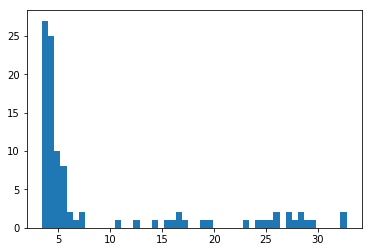

In [122]:
hist_res = found_res
plt.hist(hist_res, bins=50)
plt.show()


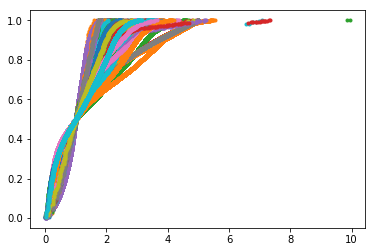

In [121]:
for r, f in zip(rs_re, fs_ie):
    plt.plot(r, f, '.')

plt.show()